# Detect chessboard

In [134]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import plotly.express as px
import pickle


Saving to D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056\multicam_video_2024-08-03T16_36_58_central.avi.overlay-0-12325.mp4


100%|█████████████████████████| 12325/12325 [00:27<00:00, 449.30frame/s]


Saving to D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056\multicam_video_2024-08-03T16_36_58_mirror-bottom.avi.overlay-0-12325.mp4


100%|████████████████████████| 12325/12325 [00:09<00:00, 1268.83frame/s]


Saving to D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056\multicam_video_2024-08-03T16_36_58_mirror-left.avi.overlay-0-12325.mp4


100%|████████████████████████| 12325/12325 [00:10<00:00, 1157.06frame/s]


Saving to D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056\multicam_video_2024-08-03T16_36_58_mirror-right.avi.overlay-0-12325.mp4


100%|████████████████████████| 12325/12325 [00:10<00:00, 1176.43frame/s]


Saving to D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056\multicam_video_2024-08-03T16_36_58_mirror-top.avi.overlay-0-12325.mp4


100%|████████████████████████| 12325/12325 [00:10<00:00, 1214.86frame/s]


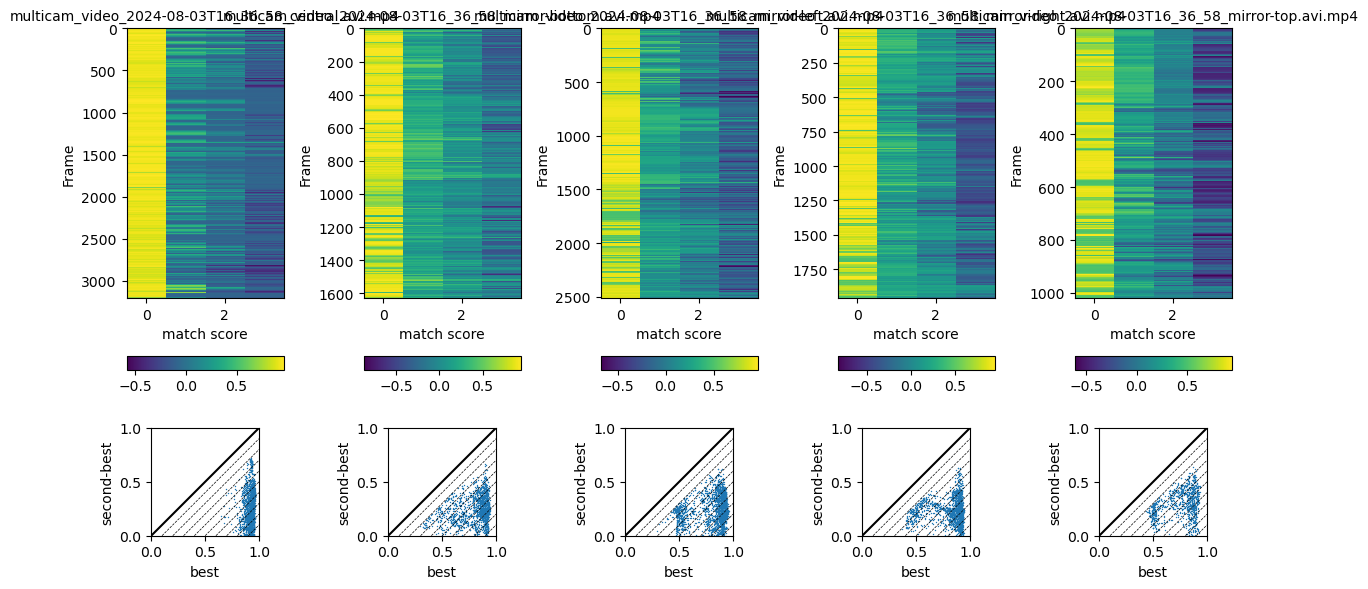

In [15]:
board_shape = (5,7)
square_size = 12.5

# camera_names = ['top', 'side1', 'side2', 'side3', 'side4', 'bottom']
# prefix = '../../tests/example_data/example_calibration'
#data_dir = Path("/Users/vigji/Desktop/dest_dir/18042024")  # /Calibration/Basler_acA1440-220um__40075240__20240418_180540771_cropped
data_dir = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241111165056")
#video_paths = sorted([f for f in (data_dir.glob("Calibration/*/*.mp4")) if "overlay" not in f.stem])[::-1]
#camera_names = [p.stem.split("_")[-1].split(".detections")[0] for p in video_paths] 

#video_paths = [str(f) for f in video_paths]
video_paths = [str(f) for f in data_dir.iterdir() if f.suffix == '.mp4' and 'overlay' not in f.stem]

#detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
for p in video_paths:
    mcc.overlay_detections(p, overwrite=True)
fig.savefig(data_dir / "checkerboard_errors.png")

In [96]:
camera_sequence = [Path(video_path).stem.split("_")[-1].split(".avi")[0] for video_path in video_paths]

# Calibrate

Check for Luigi:

- all_calib_uvs matrix when is created by the calibration images
- shape, dtype, filling values fror missed detections

All params passed to the mcc.calibrate function

In [103]:
all_calib_uvs.shape

(5, 12325, 35, 2)

## Initialization

In [16]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)
s = slice(None, None)
import flammkuchen as fl
fl.save(r"D:\SNeurobiology\Desktop\luigidelete\args_calibration.h5", dict(all_calib_uvs=all_calib_uvs[s], all_img_sizes=all_img_sizes[s], calib_objpoints=calib_objpoints))

In [17]:

all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs[:, s, :, :], all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)
fig.savefig(data_dir / "shared_detections.png")


Estimating camera intrinsics


100%|████████████████████████████████████| 5/5 [13:15<00:00, 159.18s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


Estimating camera extrinsics
Merging calibration object poses


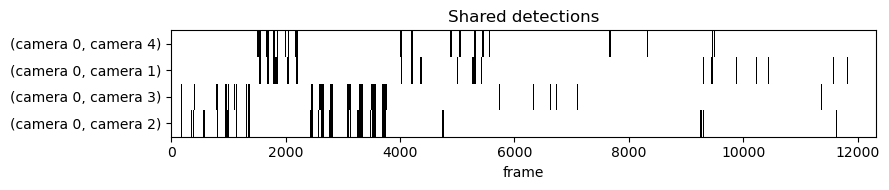

In [18]:
fig, shared_detections = mcc.plot_shared_detections(all_calib_uvs, spanning_tree)

In [19]:
valid = ((~np.isnan(all_calib_uvs[1, :, 0, 0]))&(~np.isnan(all_calib_uvs[0, :, 0, 0]))).astype(int)
np.sum(valid)

565

In [20]:
import tqdm
import cv2
n_cameras, n_frames, N, _ = all_calib_uvs.shape
median_error = np.zeros(n_cameras)
reprojections = np.zeros((n_cameras, n_frames, N, 2))
transformed_reprojections = np.zeros((n_cameras, n_frames, N, 2)) * np.nan
pts = mcc.embed_calib_objpoints(calib_objpoints, calib_poses)

errors_list = []
for cam in tqdm.trange(n_cameras):
    reprojections[cam] = mcc.project_points(
        pts, all_extrinsics[cam], all_intrinsics[cam][0]
    )
    uvs_undistorted = mcc.undistort_points(all_calib_uvs[cam], *all_intrinsics[cam])
    valid_ixs = np.nonzero(~np.isnan(uvs_undistorted).any((-1, -2)))[0]
    for t in valid_ixs:
        H = cv2.findHomography(uvs_undistorted[t], calib_objpoints[:, :2])
        transformed_reprojections[cam, t] = cv2.perspectiveTransform(
            reprojections[cam, t][np.newaxis], H[0]
        )[0]

    errors = np.linalg.norm(
        transformed_reprojections[cam, valid_ixs] - calib_objpoints[:, :2],
        axis=-1,
    )
    median_error[cam] = np.median(errors)
    errors_arr = np.zeros(n_frames)*np.nan
    errors_arr[valid_ixs] = np.median(errors, axis=1)
    errors_list.append(errors_arr)

100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


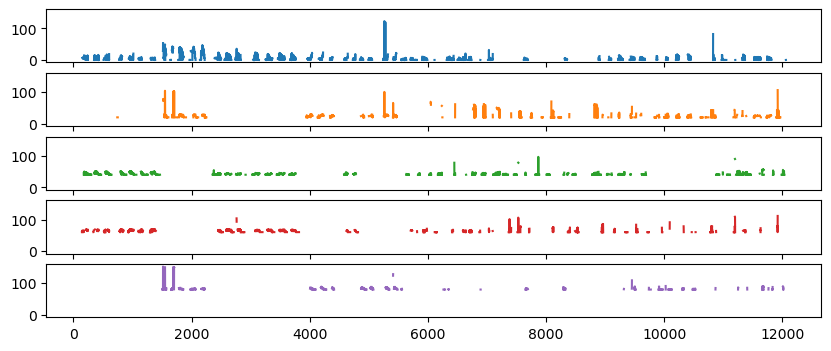

In [21]:
f, axs = plt.subplots(len(errors_list), 1, figsize=(10, 4), sharex=True, sharey=True)

for i, errors in enumerate(errors_list):
    axs[i].plot(errors + i*20, c=f"C{i}")
# plt.plot(errors_list[0].mean(1))

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


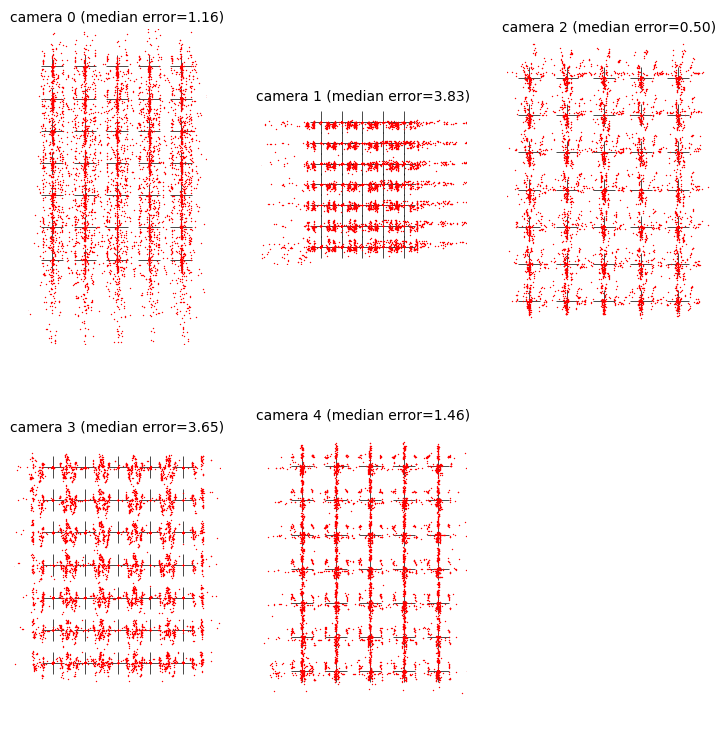

In [22]:
#    cam_names=['top', 'side1', 'side2', 'side3', 'side4', 'bottom'],
s = slice(0, None)
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:, s, :, :], all_extrinsics, all_intrinsics, calib_objpoints, calib_poses[s, :], 

    inches_per_axis=3)
fig.savefig(data_dir / "first_residuals.png")

## Bundle adjustment

In [23]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=None, ftol=1e-4)

Excluding 192 out of 2404 frames based on an outlier threshold of 27.267212873051264
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2130e+06                                    3.40e+07    
       1              7         7.3608e+05      4.77e+05       3.77e+02       1.82e+07    
       2              8         5.5521e+05      1.81e+05       3.44e+02       2.07e+07    
       3              9         4.9162e+05      6.36e+04       4.22e+02       1.15e+07    
       4             10         4.2466e+05      6.70e+04       1.12e+02       1.13e+07    
       5             11         3.9413e+05      3.05e+04       1.93e+02       1.55e+07    
       6             12         3.7733e+05      1.68e+04       1.96e+02       1.16e+07    
       7             13         3.5316e+05      2.42e+04       5.02e+01       1.13e+07    
       8             14         3.3164e+05      2.15e+04       7.73e+01       1.30e+07    
     

In [24]:
nan_counts = np.isnan(all_calib_uvs).sum((0, 1, 2, 3))

100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


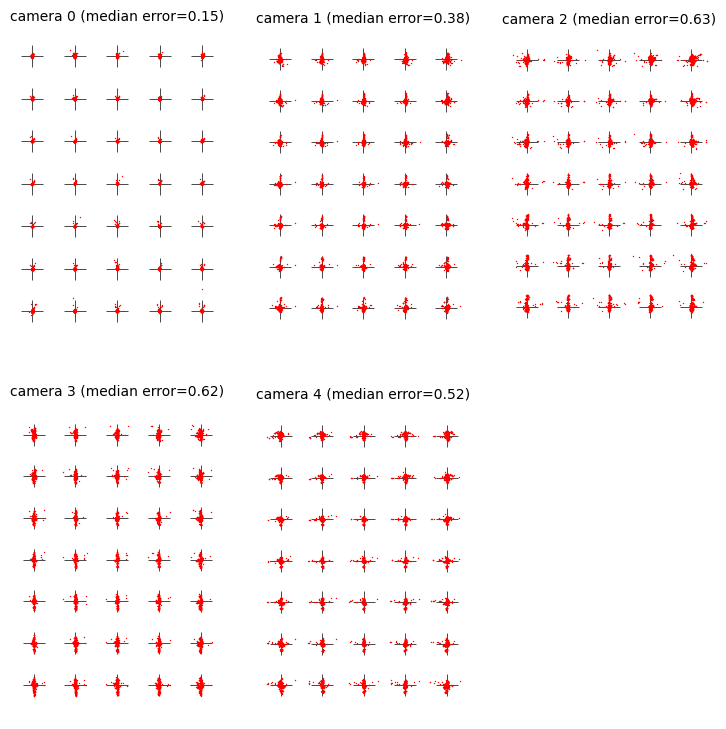

In [25]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses, inches_per_axis=3)
fig.savefig(data_dir / "refined_residuals.png")

In [128]:
def triangulate_all_keypoints(calib_uvs, adj_extrinsics, adj_intrinsics, progress_bar=True):
    all_triang = []
    progbar = tqdm if progress_bar else lambda x: x
    for i in progbar(range(calib_uvs.shape[2])):
        all_triang.append(mcc.triangulate(calib_uvs[:, :, i, :], adj_extrinsics, adj_intrinsics))
    
    return np.array(all_triang)

checkboard_3d = triangulate_all_keypoints(all_calib_uvs, adj_extrinsics, adj_intrinsics)

non_nan_idxs = np.where(~np.isnan(checkboard_3d).any(axis=(0, 2)))[0]
frame_idx = non_nan_idxs[0]
checkboard_frame = checkboard_3d[:, frame_idx, :]

100%|██████████| 35/35 [00:23<00:00,  1.49it/s]


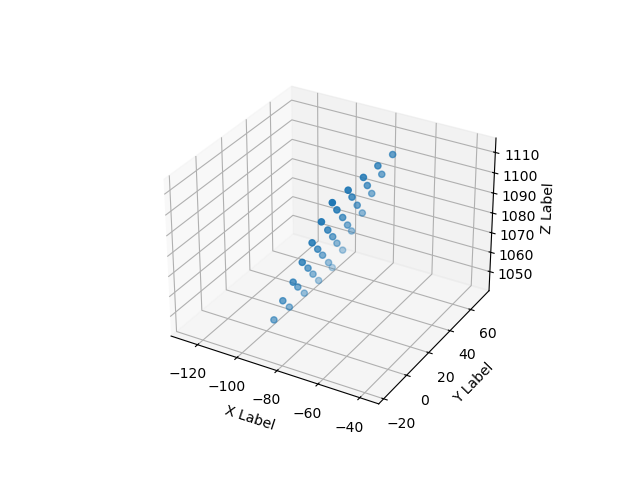

In [106]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(checkboard_frame[:, 0], checkboard_frame[:, 1], checkboard_frame[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.axis("equal")
plt.show()

In [109]:
file = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_20241111-164517.json"

import json

with open(file) as f:
    d = json.load(f)
    print(d)
coordinates = d[-1]
coordinates_ars = {}
for key, value in coordinates['points_coordinate'].items():
    coordinates_ars[key] = np.array(value)

right_arr = [coordinates_ars[cam] for cam in camera_sequence]   #[coordinates_ars['central'], coordinates_ars['mirror-bottom'], coordinates_ars['mirror-left'], coordinates_ars['mirror-right'], coordinates_ars['mirror-top']]
right_arr = np.stack([np.expand_dims(np.array(arr), 0) for arr in right_arr], 0)

arena_3d = triangulate_all_keypoints(right_arr[:, :, :, [1, 0]], adj_extrinsics, adj_intrinsics)
# arena_triangulation = []
# for i in tqdm(range(8)):
#     arena_triangulation.append(mcc.triangulate(right_arr2[:, :, i, [1, 0]], adj_extrinsics, adj_intrinsics))
# arena_triangulation = np.array(arena_triangulation).squeeze()
arena_frame = arena_3d[:, 0, :]


[{'transform': 'central', 'output_file_suffix': 'central.avi', 'filters': 'crop=608.0:624.0:246.0:238.0,format=gray', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-preset': 'superfast', '-pix_fmt': 'yuv420p', '-c:a': 'copy'}}, {'transform': 'mirror-top', 'output_file_suffix': 'mirror-top.avi', 'filters': 'crop=600.0:219.99999999999997:234.36394950087072:9.854764650609496,format=gray,transpose=2,transpose=2,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-preset': 'superfast', '-pix_fmt': 'yuv420p', '-c:a': 'copy'}}, {'transform': 'mirror-bottom', 'output_file_suffix': 'mirror-bottom.avi', 'filters': 'crop=608.0:224.0:248.32721009982583:853.3455798003483,format=gray,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '23', '-preset': 'superfast', '-pix_fmt': 'yuv420p', '-c:a': 'copy'}}, {'transform': 'mirror-left', 'output_file_suffix': 'mirror-left.avi', 'filters': 'crop=224.0:624.0:10.545924251306019:225.20034445095786,format=

100%|██████████| 8/8 [00:00<00:00, 789.33it/s]


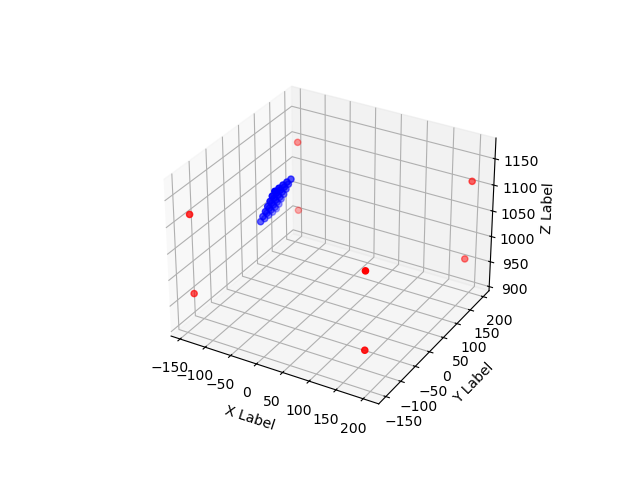

In [110]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure()
ax = fig.add_subplot(projection='3d')




ax.scatter(checkboard_frame[:, 0], checkboard_frame[:, 1], checkboard_frame[:, 2], c='b')
ax.scatter(arena_frame[:, 0], arena_frame[:, 1], arena_frame[:, 2], c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.axis("equal")
plt.show()

## check backprojections for frame

Get the coordinats of the arean on the image 

In [126]:
back_projections = {}
names = ['central', 'mirror-bottom', 'mirror-left', 'mirror-right', 'mirror-top']
for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    back_projections[names.pop(0)] = mcc.project_points(arena_frame, extrinsic, intrinsic[0], dist_coefs=intrinsic[1])


Get the coordinates of the checkboard on the image plane for each camera view

In [129]:
names = ['central', 'mirror-bottom', 'mirror-left', 'mirror-right', 'mirror-top']
checkboard_back_projections = {}

for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    checkboard_back_projections[names.pop(0)] = mcc.project_points(checkboard_frame, extrinsic, intrinsic[0], dist_coefs=intrinsic[1])

In [130]:
# get the same frame from all the videos:
import cv2
idx = frame_idx
frames = {}
names = ['central', 'mirror-bottom', 'mirror-left', 'mirror-right', 'mirror-top']
for frame, name in zip(video_paths, names):
    cap = cv2.VideoCapture(str(frame))
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    res, frame = cap.read()
    frames[name] = frame

C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_43768\1071136671.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


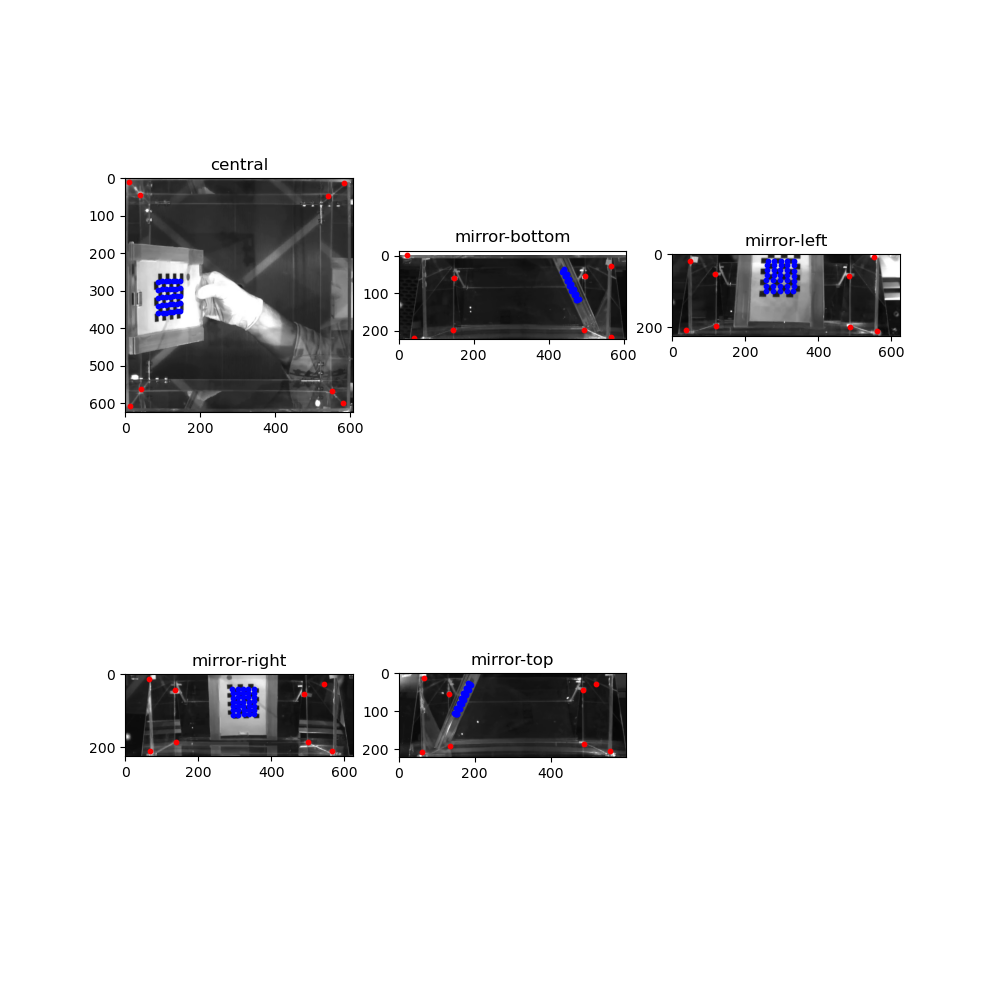

In [133]:
plt.figure(figsize=(10, 10))

for i, view in enumerate(camera_sequence):
    plt.subplot(2, 3, i+1)
    plt.imshow(frames[view], cmap='gray')
    plt.scatter(back_projections[view][:, 0], back_projections[view][:, 1], c='r', s=10)
    plt.scatter(checkboard_back_projections[view][:, 0], checkboard_back_projections[view][:, 1], c='b', s=10)
    plt.title(view)

plt.show()

Backprojections without dist_coef

In [71]:
back_projections_nodist = {}
names = ['central', 'mirror-bottom', 'mirror-left', 'mirror-right', 'mirror-top']
for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    back_projections_nodist[names.pop(0)] = mcc.project_points(arena_triangulation, extrinsic, intrinsic[0], dist_coefs=None)

In [72]:
names = ['central', 'mirror-bottom', 'mirror-left', 'mirror-right', 'mirror-top']
checkboard_back_projections_nodist = {}

for extrinsic, intrinsic in zip(adj_extrinsics, adj_intrinsics):
    checkboard_back_projections_nodist[names.pop(0)] = mcc.project_points(checkboard_3d, extrinsic, intrinsic[0], dist_coefs=None)

## plot tracked points and arean together

In [135]:
with open(r'C:\Users\SNeurobiology\code\3d-setup\notebooks\tracked_points_sample.pkl','rb') as f:
    tracked_points = pickle.load(f)


In [137]:
tracked_points_3d  = triangulate_all_keypoints(tracked_points, adj_extrinsics, adj_intrinsics)

100%|██████████| 13/13 [01:38<00:00,  7.56s/it]


In [138]:
tracked_points_3d.shape

(13, 35966, 3)

In [139]:
tracked_points_idx = 18966
tracked_points_3d_frame =  tracked_points_3d[:, tracked_points_idx, :]

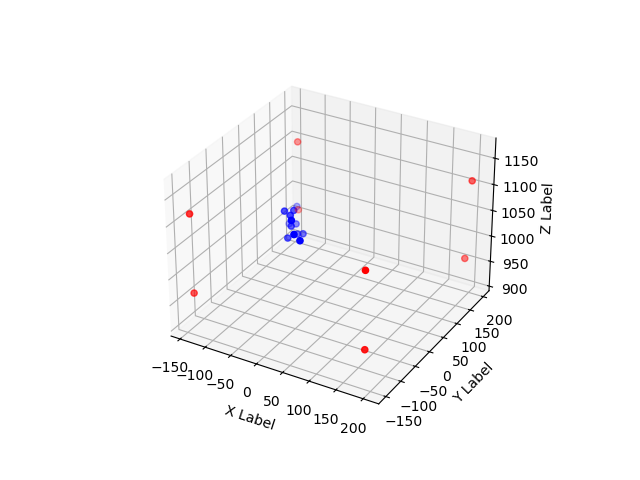

In [140]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(tracked_points_3d_frame[:, 0], tracked_points_3d_frame[:, 1], tracked_points_3d_frame[:, 2], c='b')
ax.scatter(arena_frame[:, 0], arena_frame[:, 1], arena_frame[:, 2], c='r')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.axis("equal")
plt.show()

# Save results

In [15]:
# save for JARVIS
camera_names = ['bottom', 'side1', 'side2', 'side3', 'side4']
video_dir = data_dir / "calibration_vals"
save_path = f'{video_dir}/CalibrationParameters/'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='jarvis')

# save for GIMBAL
save_path = f'{video_dir}/camera_params.h5'
mcc.save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='gimbal')
# save for GIMBAL
save_path = f'{video_dir}/camera_params_adj.h5'
mcc.save_calibration(adj_extrinsics, adj_intrinsics, camera_names, save_path, save_format='gimbal')

In [5]:
save_path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240801\Calibration\multicam_video_2024-08-01T18_03_33_cropped_20240923170906\calibration_vals\camera_params_adj.h5"

## Triangulation

In [6]:
data = mcc.load_calibration(save_path, load_format='gimbal')

In [7]:
all_extrinsics, all_intrinsics, camera_names = data

In [14]:
[all_intrinsic[1] for all_intrinsic in all_intrinsics]

[array([  0.0494364 , -25.06062299,   0.        ,   0.        ,
          0.        ]),
 array([-0.7539732 ,  3.12432008,  0.        ,  0.        ,  0.        ]),
 array([-0.5299353 , -2.51784989,  0.        ,  0.        ,  0.        ]),
 array([ 2.86079689e-02, -3.39390204e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]),
 array([  1.41974757, -45.1377946 ,   0.        ,   0.        ,
          0.        ])]

In [146]:
import pickle
with open(r'C:\Users\SNeurobiology\code\3d-setup\notebooks\tracked_points_sample.pkl','rb') as f:
    tracked_points = pickle.load(f)



In [147]:
tracked_points.shape

(5, 35966, 13, 2)

In [258]:
all_extrinsics, all_intrinsics = np.array(all_extrinsics), np.array(all_intrinsics)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 2) + inhomogeneous part.

In [259]:
(adj_extrinsics*1000).astype(int)

NameError: name 'adj_extrinsics' is not defined

In [260]:
(all_extrinsics*1000).astype(int)

AttributeError: 'list' object has no attribute 'astype'

In [151]:
# triangulation:
i = 18966
point_01 = tracked_points[:, i:i+1, ...]
point_01.shape

(5, 1, 13, 2)

In [152]:
# concatenated_arr = [np.expand_dims(np.array(arr), 0) for arr in point_01]
# right_arr = np.stack(concatenated_arr, axis=0)

all_triang = []
for i in tqdm(range(tracked_points.shape[2])):
    all_triang.append(mcc.triangulate(point_01[:, :,i , [1, 0]], all_extrinsics, all_intrinsics))
all_triang = np.array(all_triang)
data = all_triang
data = data.reshape(13, 3)

100%|██████████| 13/13 [00:00<00:00, 764.78it/s]


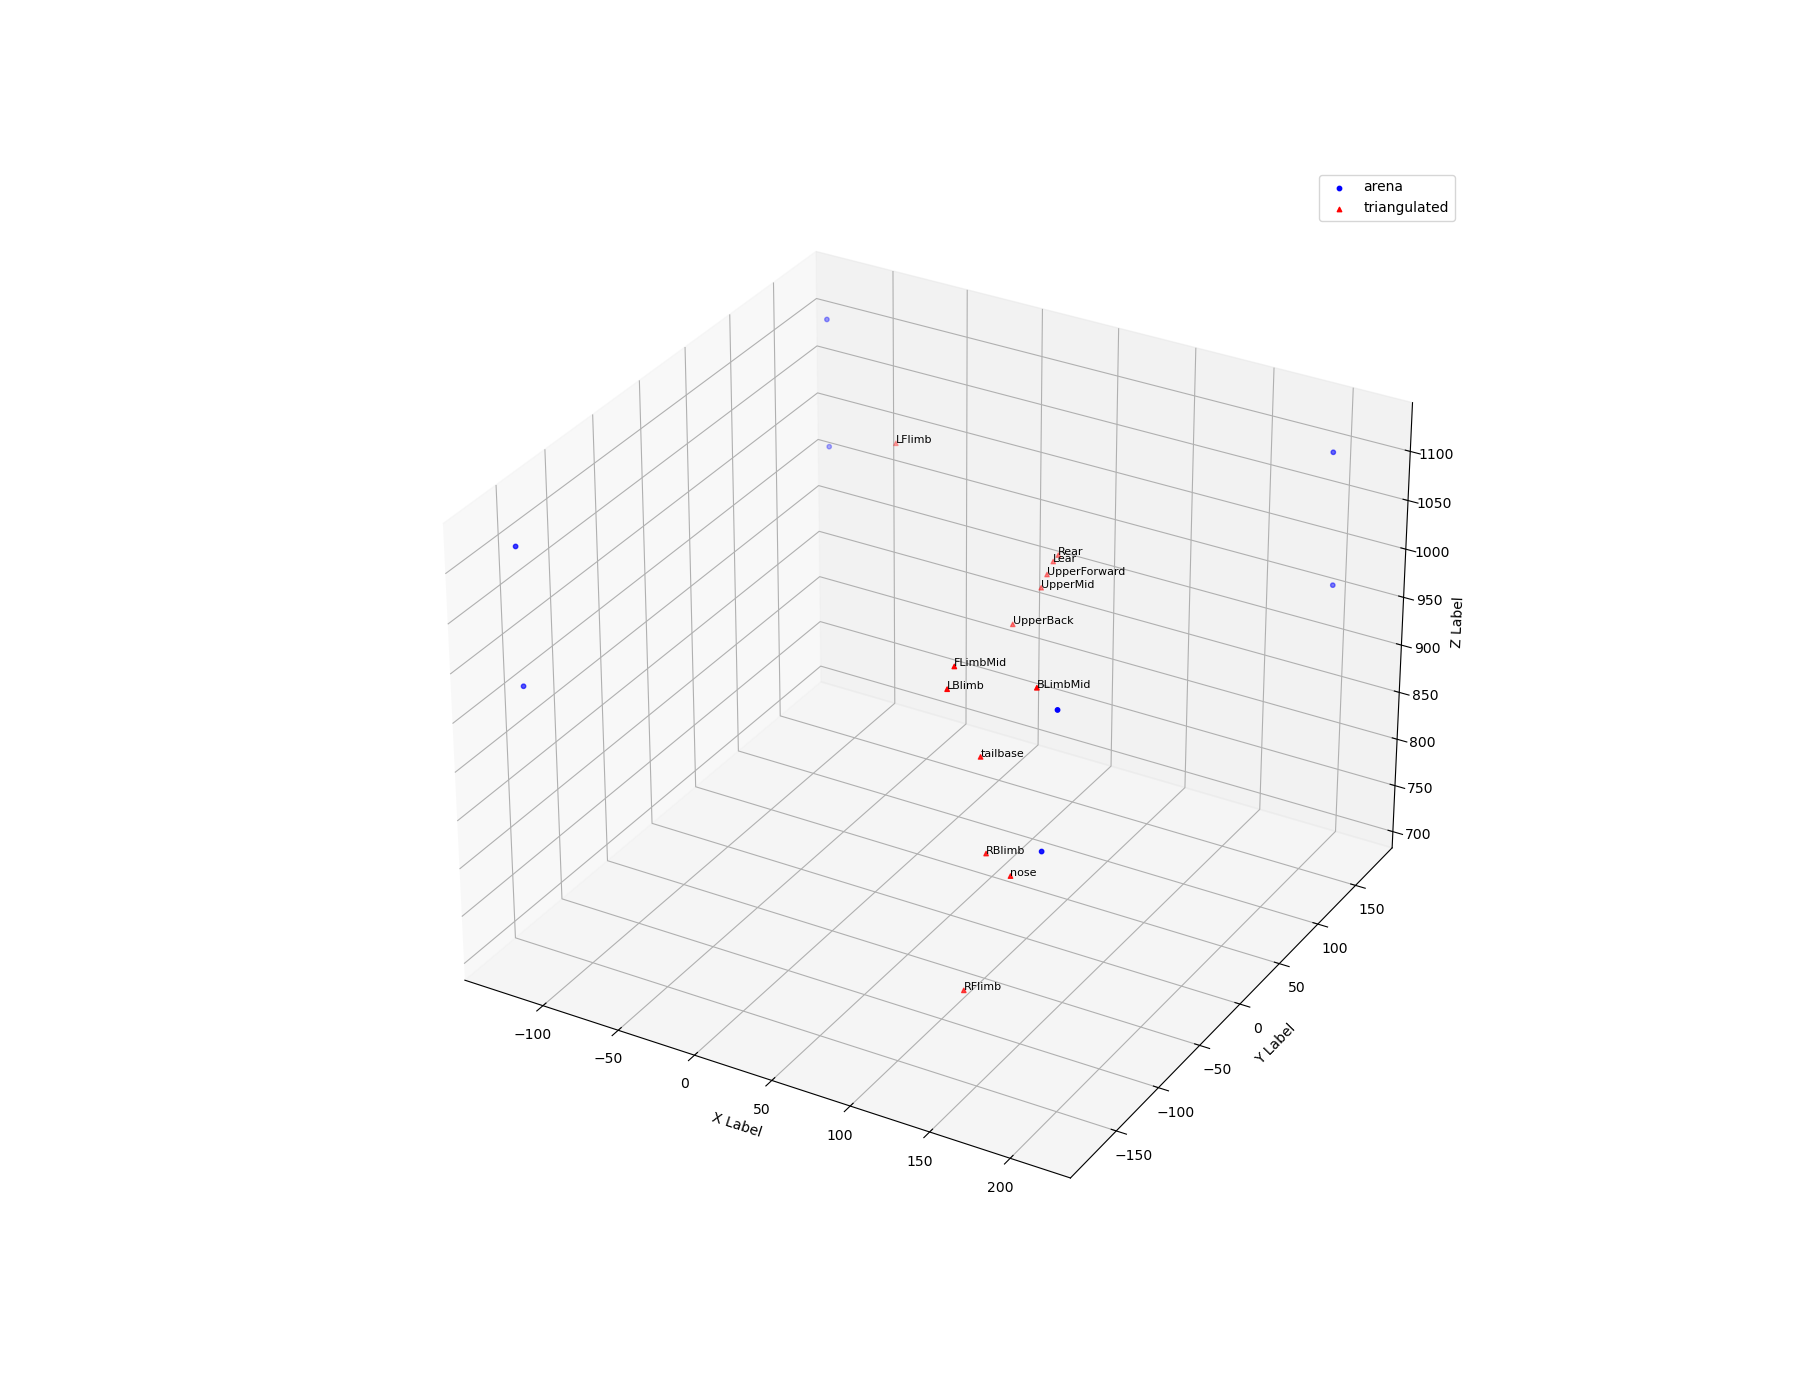

In [153]:
postural_names =  ['nose',
  'Lear',
  'Rear',
  'LFlimb',
  'RFlimb',
  'FLimbMid',
  'LBlimb',
  'RBlimb',
  'BLimbMid',
  'tailbase',
  'UpperForward',
  'UpperMid',
  'UpperBack']


fig = plt.figure(figsize=(18, 14))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(arena_triangulation[:, 0], arena_triangulation[:, 1], arena_triangulation[:, 2], c='blue', marker='o', label='arena', s=10)


ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red', marker='^', label='triangulated', s=10)

for i, name in enumerate(postural_names):
    ax.text(data[i, 0], data[i, 1], data[i, 2], name, color='black', fontsize=8)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()

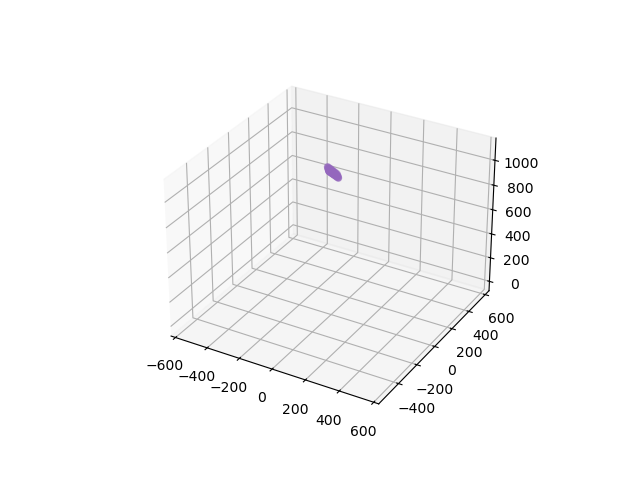

In [176]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(10):
    off = 8000 + i*10
    ax.scatter(all_triang[:, off, 0], all_triang[:, off, 1],all_triang[:, off, 2] )
# ax.scatter(all_triang[:, ::100, 0].flatten(), 
#            all_triang[:, ::100, 1].flatten(),
#            all_triang[:, ::100, 2].flatten() )
set_axes_equal(ax)

## Check arean coordinates, plot arena 3d, sanaty check

In [222]:
file = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_20241108-143350.json"

import json

with open(file) as f:
    d = json.load(f)
    print(d)
coordinates = d[-1]
coordinates_ars = {}
for key, value in coordinates['points_coordinate'].items():
    coordinates_ars[key] = np.array(value)

all_arr = list(coordinates['points_coordinate'].values())
concatenated_arr = [np.expand_dims(np.array(arr), 0) for arr in all_arr]
right_arr = np.stack(concatenated_arr, axis=0)

arena_triangulation = []
for i in tqdm(range(8)):
    arena_triangulation.append(mcc.triangulate(right_arr[:, :, i, [1, 0]], all_extrinsics, all_intrinsics))
arena_triangulation = np.array(arena_triangulation).squeeze()



[{'transform': 'central', 'output_file_suffix': 'central.avi', 'filters': 'crop=600.0:620.0:250.0:240.0,format=gray', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '1', '-preset': 'veryfast', '-pix_fmt': 'gray', '-c:a': 'copy'}}, {'transform': 'mirror-top', 'output_file_suffix': 'mirror-top.avi', 'filters': 'crop=600.0:220.0:250.0:20.0,format=gray,transpose=2,transpose=2,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '1', '-preset': 'veryfast', '-pix_fmt': 'gray', '-c:a': 'copy'}}, {'transform': 'mirror-bottom', 'output_file_suffix': 'mirror-bottom.avi', 'filters': 'crop=600.0:220.0:250.0:860.0,format=gray,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '1', '-preset': 'veryfast', '-pix_fmt': 'gray', '-c:a': 'copy'}}, {'transform': 'mirror-left', 'output_file_suffix': 'mirror-left.avi', 'filters': 'crop=220.0:620.0:30.0:240.0,format=gray,transpose=2,hflip', 'ffmpeg_args': {'-c:v': 'libx264', '-b:v': '30M', '-crf': '1', '-preset': 'veryfa

In [223]:
coordinates = d[-1]

### check points arena over frames

In [86]:
coordinates_views = coordinates['points_coordinate']

for key, value in coordinates_views.items():
    coordinates_views[key] = np.array(value)

In [87]:
coordinates_views['central'][:, 0].shape

(8,)

In [88]:
import os
import sys

sys.path.append("../complete_pipeline")
from utils import  read_first_frame

In [96]:
# display each coordinate on the cropped image, 
import cv2
import matplotlib.pyplot as plt
from pathlib import Path


dir_path = Path(r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\test_cropping\calibration_retest\Calibration\multicam_video_2024-08-03T16_36_58_cropped_20241108143758_recal")
first_frames ={}
names = ['central', 'bottom', 'left', 'right', 'top'] 
a = -1
for i in dir_path.iterdir():
    if i.suffix == '.mp4':
        a += 1
        



        video_path = i
        first_frames[names[a]]= read_first_frame(str(video_path))

In [97]:
first_frames_n = {}
for value, key in zip(first_frames.values(), coordinates_views.keys()):
    first_frames_n[key] = value

In [98]:
first_frames_n.keys()

dict_keys(['central', 'mirror-top', 'mirror-bottom', 'mirror-left', 'mirror-right'])

In [99]:
coordinates_views.keys()

dict_keys(['central', 'mirror-top', 'mirror-bottom', 'mirror-left', 'mirror-right'])

In [232]:
plt.clf()

<Figure size 640x480 with 0 Axes>

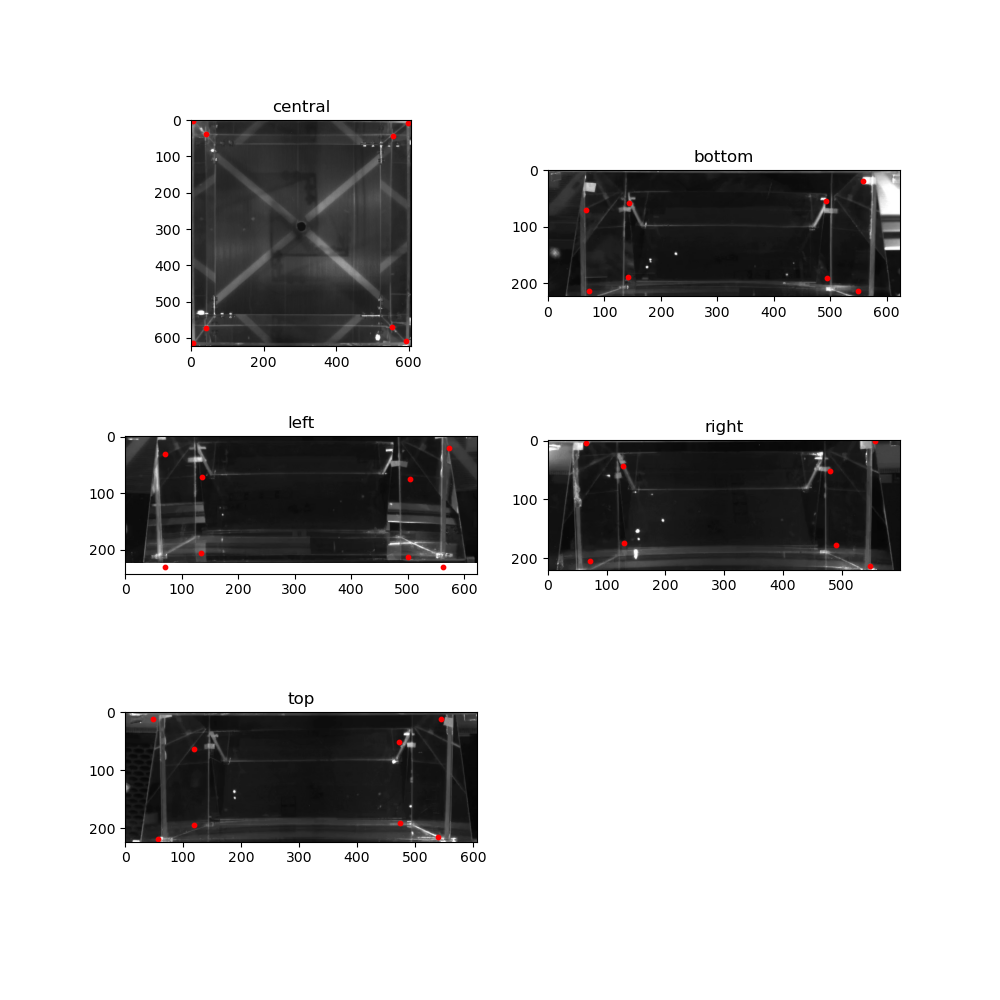

In [100]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.imshow(first_frames_n['central'], cmap='gray')
plt.scatter(coordinates_views['central'][:, 1], coordinates_views['central'][:, 0], c='r', s=10)
plt.title('central')


plt.subplot(3, 2, 2)
plt.imshow(first_frames_n['mirror-bottom'], cmap='gray')
plt.scatter(coordinates_views['mirror-bottom'][:, 1], coordinates_views['mirror-bottom'][:, 0], c='r', s=10)
plt.title('bottom')


plt.subplot(3, 2, 3)
plt.imshow(first_frames_n['mirror-left'], cmap='gray')
plt.scatter(coordinates_views['mirror-left'][:, 1], coordinates_views['mirror-left'][:, 0], c='r', s=10)
plt.title('left')

plt.subplot(3, 2, 4)
plt.imshow(first_frames_n['mirror-right'], cmap='gray')
plt.scatter(coordinates_views['mirror-right'][:, 1], coordinates_views['mirror-right'][:, 0], c='r', s=10)
plt.title('right')

plt.subplot(3, 2, 5)
plt.imshow(first_frames_n['mirror-top'], cmap='gray')
plt.scatter(coordinates_views['mirror-top'][:, 1], coordinates_views['mirror-top'][:, 0], c='r', s=10)
plt.title('top')

plt.show()

### plot triangulation arean

In [234]:
coordinates_ars = {}
for key, value in coordinates['points_coordinate'].items():
    coordinates_ars[key] = np.array(value)
    

In [235]:
all_arr = list(coordinates['points_coordinate'].values())
concatenated_arr = [np.expand_dims(np.array(arr), 0) for arr in all_arr]
right_arr = np.stack(concatenated_arr, axis=0)

In [238]:
all_triang1 = []
for i in tqdm(range(8)):
    all_triang1.append(mcc.triangulate(right_arr[:, :, i, [1, 0]], all_extrinsics, all_intrinsics))
all_triang1 = np.array(all_triang1)

100%|██████████| 8/8 [00:00<00:00, 889.05it/s]


In [239]:
all_triang1

array([[[-145.62352441, -122.53988198,  997.02773662]],

       [[ -48.96316666,   87.40233169,  978.2773667 ]],

       [[ 111.94009707,  125.9858447 ,  978.15479722]],

       [[  41.83694647,  -55.07641622,  988.32183462]],

       [[-142.55462875, -114.24039615, 1131.63637924]],

       [[ -56.23045699,   35.83571031, 1144.52131981]],

       [[ 123.60938242,  157.13034347, 1104.56186441]],

       [[  11.12777354,  -71.32077489, 1132.61205798]]])

In [246]:
data

(8, 3)

In [247]:
data = all_triang1
data_coordinates_arena = data.squeeze()


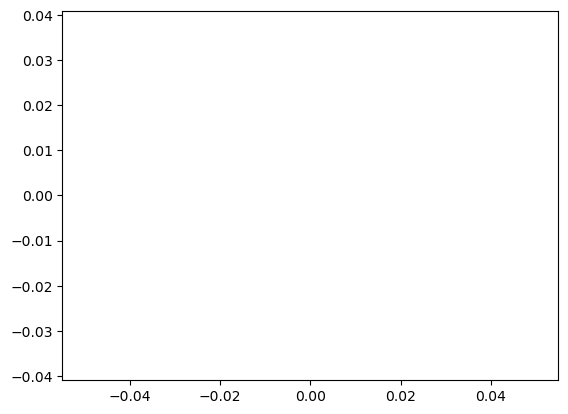

In [249]:
import plotly.express as px

fig = px.scatter_3d(x=data_coordinates_arena[:, 0], y=data_coordinates_arena[:, 1], z=data_coordinates_arena[:, 2], text=range(8))
plt.axis('equal')
fig.show()

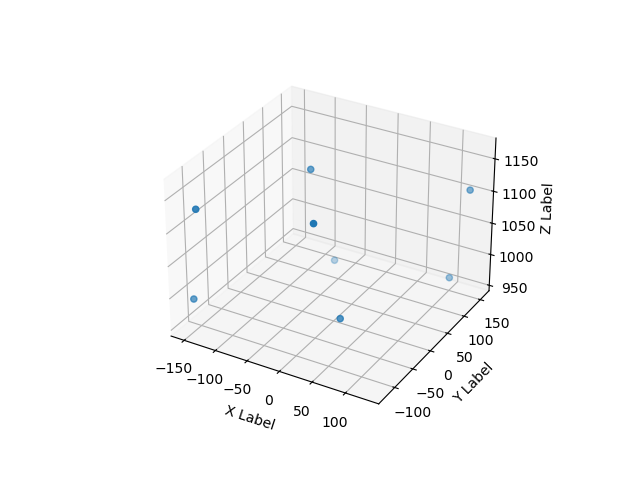

In [252]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np



fig = plt.figure()
ax = fig.add_subplot(projection='3d')




ax.scatter(data_coordinates_arena[:, 0], data_coordinates_arena[:, 1], data_coordinates_arena[:, 2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.axis("equal")
plt.show()

### Sanity Check

In [130]:
# plot the same point over each  frame to check for consistency
import pickle
coord_path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240803\M4\140337\right_coords.pkl"
with open(coord_path, 'rb') as f:
    coordinates = pickle.load(f)

In [133]:

ars = [value for value in coordinates.values()]
uncropped_coordinates = np.stack(ars, axis=0)

In [135]:
uncropped_coordinates[:, 0, :]

array([[ 239.87171421,  251.50775583],
       [  19.37169779,  302.87661533],
       [1047.91295656,  359.43230244],
       [ 298.57021474,   20.83517485],
       [ 366.19973994, 1028.05280287]])

In [136]:
%gui qt5

In [141]:
import napari
from utils import read_first_frame
path = r"D:\P05_3DRIG_YE-LP\e01_mouse_hunting\v04_mice-hunting\20240803\M4\140337\multicam_video_2024-08-03T14_32_11.avi"
frame = read_first_frame(path)


def inspect_id(frame, i):

    viewer = napari.Viewer()
    viewer.add_image(frame, name="uncropped", contrast_limits=[0, 255])


    points_layer = viewer.add_points(
    uncropped_coordinates[:, i, :],
    size=10,
    name="points",
    edge_color="white",
    edge_width=0.5,
    )
    points_layer.editable = True

    napari.run()
    adjusted_points = points_layer.data


In [142]:
for i in range(8):
    inspect_id(frame, i)

C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_32252\1693368917.py:13: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  points_layer = viewer.add_points(
c:\Users\SNeurobiology\miniconda3\envs\lab-env\lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_color' is deprecated, please use 'border_color' instead. The argument 'edge_color' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  return func(*args, **kwargs)
C:\Users\SNeurobiology\AppData\Local\Temp\ipykernel_32252\1693368917.py:13: FutureWarning: Argument 'edge_width' is deprecated, please use 'border_width' instead. The argument 'edge_width' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  points_layer = viewer.add_points(
c:\Users\SNeurobiology\miniconda3\envs\lab-env\lib\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_color' is d

Here the identities of the points look fine (check only top bottom in central for left point)

Next steps for calibration correction:

- Check identity before cropping
- Check identity after cropping again
- Check if video for calibration are distorting the points

- check expected cameras and stack array